In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np


data_root = '../../MyData/'

In [2]:
data = pd.read_csv("target_column.csv").drop('tic', axis=1)

In [3]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()
scaler.fit(data)
scaled_np = scaler.transform(data)

scaled_tensor = torch.tensor(scaled_np)
print(scaled_tensor)
scaled_tensor.size()
# tensor = torch.tensor(data.drop("tic", axis=1).values, dtype=torch.float)

tensor([[0.0887, 0.1558, 0.7878,  ..., 0.7836, 0.6128, 0.3303],
        [0.8128,    nan, 0.7878,  ..., 0.4616, 0.5509, 0.0626],
        [0.3437, 0.0581, 0.3942,  ..., 0.5127, 0.1444,    nan],
        ...,
        [   nan,    nan, 0.9553,  ..., 0.3748, 0.3452, 0.7362],
        [0.8046, 0.8238, 0.1651,  ..., 0.1080, 0.1149, 0.9024],
        [0.8917, 0.9129, 0.0891,  ..., 0.4674, 0.4825, 0.7362]],
       dtype=torch.float64)


torch.Size([1197, 279])

In [48]:
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
batch_size = 32

# Wrap the tensor in a dataset
dataset = TensorDataset(scaled_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [46]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob=0.3):
        super(Autoencoder, self).__init__()
        
        # Encoder with Batch Normalization and Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),  # BatchNorm before activation
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Dropout after activation
            nn.Linear(512, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # BatchNorm before activation
            nn.ReLU(),
            # nn.Dropout(dropout_prob)  # Dropout after activation
        )
        
        # Decoder with Batch Normalization and Dropout
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.BatchNorm1d(512),  # BatchNorm before activation
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Dropout after activation
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [15]:
def nan_mse_loss(output, target, nan_mask):
    # Mask NaN values
    mask = ~nan_mask
    # Compute squared error only for non-NaN values
    squared_error = (output[mask] - target[mask]) ** 2
    return squared_error.mean()


In [49]:
input_dim = 279
hidden_dim = 128  # Dimension of the compressed representation
autoencoder = Autoencoder(input_dim, hidden_dim)

# Define loss function and optimizer
criterion = nan_mse_loss
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)


# Training loop
epochs = 100



for epoch in range(epochs):
    autoencoder.train()
    total_loss = 0
    for batch in dataloader:

        inputs = batch[0]  # Get the batch
        nan_mask = torch.isnan(inputs)
        # column_means = torch.nanmean(inputs, dim=0)  # Calculate the mean of each column
        # inputs[nan_mask] = column_means.repeat(inputs.shape[0], 1)[nan_mask]  # Replace NaNs with column mean
        inputs = torch.nan_to_num(inputs, nan=0.0)
        inputs = inputs.float()


        outputs = autoencoder(inputs)  # Forward pass
        loss = criterion(outputs, inputs, nan_mask)  # Compute loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss*100: {total_loss * 100 / len(dataloader):.4f}")


Epoch [1/100], Loss*100: 6.4328
Epoch [2/100], Loss*100: 4.7476
Epoch [3/100], Loss*100: 4.1476
Epoch [4/100], Loss*100: 3.8316
Epoch [5/100], Loss*100: 3.6507
Epoch [6/100], Loss*100: 3.4220
Epoch [7/100], Loss*100: 3.3265
Epoch [8/100], Loss*100: 3.1618
Epoch [9/100], Loss*100: 3.0944
Epoch [10/100], Loss*100: 3.0412
Epoch [11/100], Loss*100: 2.9839
Epoch [12/100], Loss*100: 2.8840
Epoch [13/100], Loss*100: 2.7691
Epoch [14/100], Loss*100: 2.7427
Epoch [15/100], Loss*100: 2.6567
Epoch [16/100], Loss*100: 2.6657
Epoch [17/100], Loss*100: 2.5869
Epoch [18/100], Loss*100: 2.5944
Epoch [19/100], Loss*100: 2.5543
Epoch [20/100], Loss*100: 2.5473
Epoch [21/100], Loss*100: 2.4607
Epoch [22/100], Loss*100: 2.4183
Epoch [23/100], Loss*100: 2.3882
Epoch [24/100], Loss*100: 2.4038
Epoch [25/100], Loss*100: 2.3792
Epoch [26/100], Loss*100: 2.2959
Epoch [27/100], Loss*100: 2.3080
Epoch [28/100], Loss*100: 2.3321
Epoch [29/100], Loss*100: 2.2820
Epoch [30/100], Loss*100: 2.3047
Epoch [31/100], Los

torch.Size([279])

In [50]:
autoencoder.eval()

temp_point = scaled_tensor[3:8]
print(temp_point.size())
temp_mask = torch.isnan(temp_point)
temp_point = torch.nan_to_num(temp_point, nan=0.0)
print(temp_point.size())
temp_point = temp_point.float()

print(temp_point)
temp_output = autoencoder(temp_point)
print(temp_output)

criterion(temp_output, temp_point, temp_mask)

torch.Size([5, 279])
torch.Size([5, 279])
tensor([[0.2736, 0.1231, 0.6455,  ..., 0.2383, 0.2812, 0.0000],
        [0.3595, 0.4413, 0.7878,  ..., 0.6483, 0.6892, 0.1537],
        [0.6937, 0.7426, 0.3385,  ..., 0.2468, 0.3247, 0.0000],
        [0.4880, 0.5536, 0.6540,  ..., 0.9563, 0.9609, 0.0000],
        [0.5010, 0.5625, 0.6347,  ..., 0.9433, 0.8656, 0.5546]])
tensor([[0.3781, 0.3432, 0.6228,  ..., 0.3608, 0.3107, 0.5633],
        [0.3747, 0.4432, 0.7201,  ..., 0.5878, 0.6058, 0.2965],
        [0.6736, 0.7907, 0.2733,  ..., 0.3027, 0.3485, 0.5736],
        [0.6315, 0.6415, 0.6622,  ..., 0.8640, 0.8607, 0.2353],
        [0.6822, 0.6545, 0.6065,  ..., 0.9101, 0.8649, 0.4574]],
       grad_fn=<SigmoidBackward0>)


tensor(0.0083, grad_fn=<MeanBackward0>)

In [33]:
temp_point.size()

torch.Size([1238])

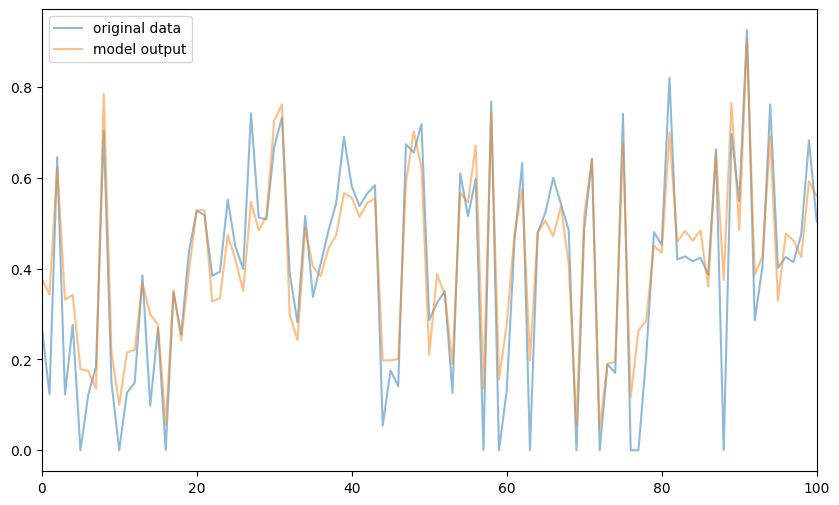

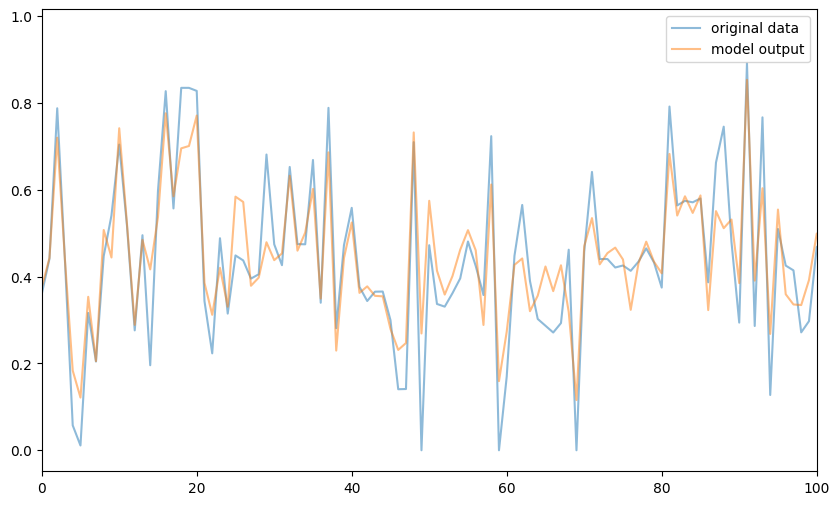

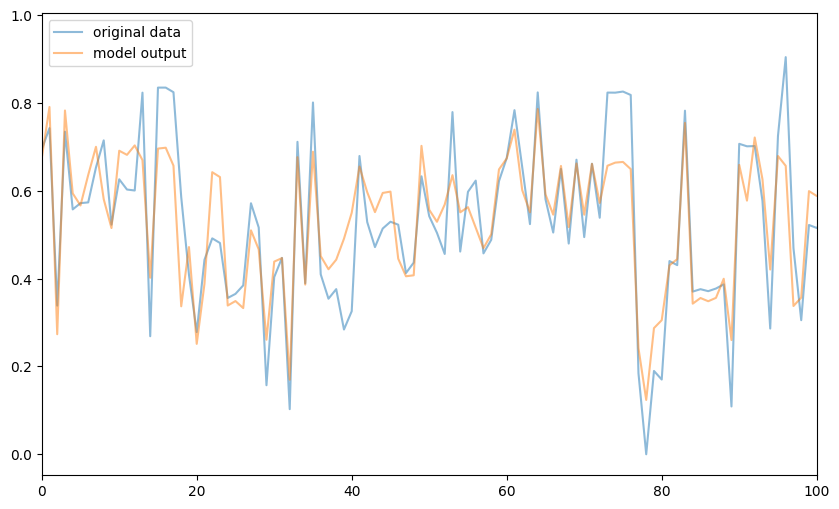

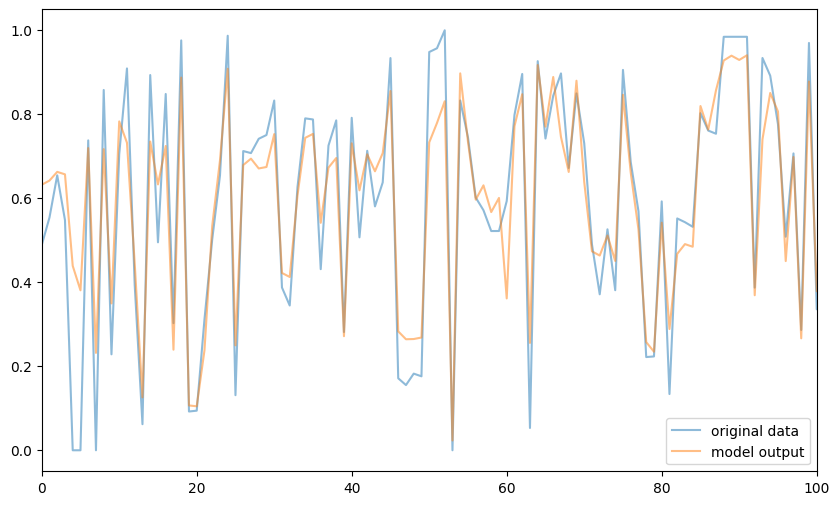

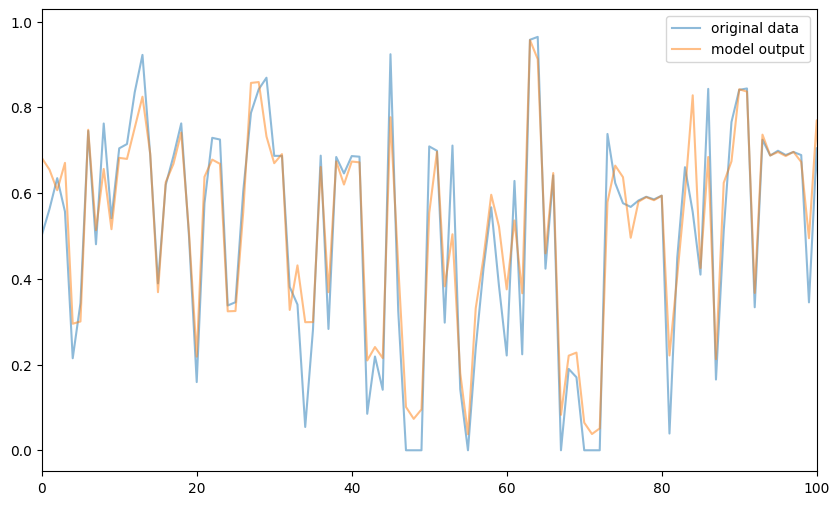

In [51]:
import matplotlib.pyplot as plt

# temp_point = temp_point[~temp_mask]
# temp_output = temp_output[~temp_mask]

for i in range(5):
    l1 = temp_point[i][~temp_mask[i]]
    l2 = temp_output[i].detach().numpy()[~temp_mask[i]]

    plt.figure(figsize=(10, 6))

    plt.plot(l1, alpha=0.5, label="original data")
    plt.plot(l2, alpha=0.5, label="model output")

    plt.xlim(0, 100)
    # plt.ylim(-0.05, 0.2)
    plt.legend()

    plt.show()

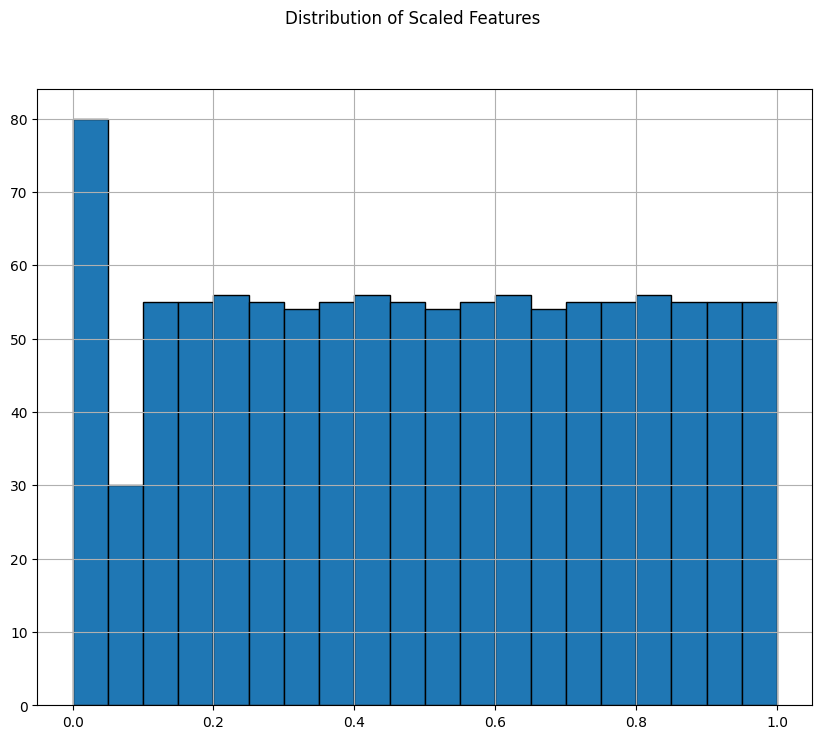

In [41]:
scaled_df = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
# Plot the distribution of each column
scaled_df['aco'].hist(bins=20, figsize=(10, 8), edgecolor='black')
plt.suptitle('Distribution of Scaled Features')
plt.show()

In [161]:
temp_output[0].size()

torch.Size([279])

## Test

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

def masked_loss(reconstructed, original, mask):
    mse_loss = (mask * (reconstructed - original) ** 2).sum(dim=1) / mask.sum(dim=1)
    return mse_loss.mean()

# Example usage
input_dim = 10
latent_dim = 4
model = Autoencoder(input_dim, latent_dim)

# Example batch
batch_size = 5
data = torch.rand(batch_size, input_dim)
mask = (torch.rand(batch_size, input_dim) > 0.2).float()  # 20% missing
data[mask == 0] = 0  # Replace missing values with 0 (or another placeholder)

# Forward pass
reconstructed = model(data)

# Compute loss
loss = masked_loss(reconstructed, data, mask)
print("Loss:", loss.item())


In [ ]:
# Sample DataFrame
data = {
    "Feature1": [1.0, 2.0, np.nan],
    "Feature2": [4.0, np.nan, 6.0],
    "Feature3": [7.0, 8.0, 9.0],
}
df = pd.DataFrame(data)

# Create a mask (1 for non-NaN, 0 for NaN)
mask = df.notna().astype(int)

# Convert DataFrame to PyTorch tensor
tensor_data = torch.tensor(df.fillna(0).values, dtype=torch.float32)
tensor_mask = torch.tensor(mask.values, dtype=torch.float32)

# Apply mask to the tensor data
masked_tensor = tensor_data * tensor_mask

print("Original DataFrame:\n", df)
print("Mask:\n", mask)
print("Tensor Data:\n", tensor_data)
print("Masked Tensor:\n", masked_tensor)
